Theory:
--

Decision Tree algorithms are very transparent in their "decision-making". Thus it will be tried to distinguish the most characteristic features of each pretrained RL model from the rl-baselines-zoo through using a Random Forest Classifier. 

Workflow:

1. Focus on a single obs in the env for all models
2. Split the obs trajectories from each model into sub trajetories
3. Generate meta data for each sub trajectory
4. Receive a DataFrame with each sub trajetory being a sample from a certain model and every meta data value a feature
5. Predict the model using the meta data
6. Analyse the most important features for the prediction


7. Follow the same strategy with all observations to create VERY many features 

Imports
--

In [82]:
!git clone https://github.com/philippwulff/behaviour_mining.git

fatal: destination path 'behaviour_mining' already exists and is not an empty directory.


In [0]:
import os

import numpy as np
import pandas as pd

from scipy.signal import find_peaks

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get data

In [0]:
def read_all(folder, nrows=None):
    """
    Read all .csv files from a directory and return the pandas Dataframes.
    """
    dfs = {}

    for root,dirs,files in os.walk(folder):
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, str(file))
                print('Creating DataFrame from {}'.format(path))
                df = pd.read_csv(path, nrows=nrows)
                dfs[path] = df

    return dfs

In [85]:
# Reduce datacount so to not exceed RAM
nrows = None
path = 'behaviour_mining/data/BipedalWalker-v3/'
dfs = read_all(path, nrows)

Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ddpg/ddpg_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/sac/sac_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/td3/td3_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/acktr/acktr_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/trpo/trpo_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/a2c/a2c_BipedalWalker-v3.csv


In [86]:
dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv'].head()

,done,rewards,cumulative_reward,obs_0,obs_1,obs_2,obs_3,obs_4,obs_5,obs_6,obs_7,obs_8,obs_9,obs_10,obs_11,obs_12,obs_13,obs_14,obs_15,obs_16,obs_17,obs_18,obs_19,obs_20,obs_21,obs_22,obs_23,action_0,action_1,action_2,action_3
0,0.0,-0.152152,0.000000,-1.553152,0.058755,-2.111050,-0.150687,2.715659,0.936015,0.653329,-1.196846,1.073211,-3.279606,1.274947,-0.284248,-1.137195,1.535426,3.946275,3.969125,3.979726,3.973202,3.942354,3.876772,3.759370,3.565766,1.510411,0.112139,-0.473087,-1.000000,0.267759,-1.000000
1,0.0,-0.116266,-0.152152,-1.476143,0.548042,-2.000170,-0.556585,2.694441,-0.067539,0.361258,-1.196319,-0.931783,-3.029333,1.087949,-0.521497,-1.137885,-0.651285,3.890856,3.913426,3.923912,3.917504,3.887100,3.822428,3.706634,3.515666,1.510411,0.112139,-1.000000,-1.000000,0.271426,-0.428934
2,0.0,-0.155962,-0.268418,-1.393407,0.584033,-1.963198,-0.578523,2.501582,-0.995438,0.164044,-0.819076,-0.931783,-2.879289,0.738007,-0.285848,0.999536,-0.651285,3.832627,3.854902,3.865268,3.858983,3.829043,3.765327,3.651223,3.463026,1.510411,0.112139,-1.000000,-0.224652,1.000000,0.632351
3,0.0,-0.173834,-0.424380,-1.288625,0.738060,-1.942015,-1.047063,2.249776,-1.258509,-0.106864,-1.196320,-0.931783,-2.497924,1.714268,-0.415467,-0.698416,-0.651285,3.730530,3.752289,3.762444,3.756373,3.727250,3.665209,3.554070,3.370729,1.510411,0.112139,-0.879462,-1.000000,0.655143,-0.277381
4,0.0,-0.156413,-0.598214,-1.163460,0.881893,-1.908166,-1.135971,1.999996,-1.258509,-0.379750,-1.186960,-0.931783,-2.496081,0.046901,-0.158971,1.127991,-0.651285,3.621193,3.642399,3.652328,3.646487,3.618237,3.557990,3.450026,3.271887,1.510411,0.112139,-0.330683,-0.005658,-0.428750,0.846328


# Creating the meta data from trajectories

Using these meta data features:

```
    columns = ['mean', 'std', 'median', 'quant_25', 'quant_75', 'loc_max_mean', 
               'loc_max_num', 'loc_min_mean', 'loc_min_num', 'freq_iv', 'strongest_freq']
```

Helper functions
--

In [0]:
def split_ser(ser, n=100):
    num_splits = int(len(ser)/n)
    splits = []
    for i in range(num_splits):
        splits.append(ser[i*n:(i+1)*n])

    return splits


def ser_to_meta(x, obs_name=None):
    mean = np.mean(x)
    std = np.std(x)
    median = np.median(sorted(x))
    quant_25 = np.quantile(sorted(x), 0.25)
    quant_75 = np.quantile(sorted(x), 0.75)

    # find all local maxima with a min distance of 10 between them
    loc_max, _ = find_peaks(x, distance=10)
    loc_max_mean = np.mean(x[loc_max])
    loc_max_num = len(loc_max)
    # find all local minima with a min distance of 10 between them
    loc_min, _ = find_peaks(x*-1, distance=10)
    loc_min_mean = np.mean(x[loc_min])
    loc_min_num = len(loc_min)

    # find n_bins strongest present frequencies with fast fourier transform
    n_bins = 5
    fft = np.fft.fft(x)
    T = 1 # sampling interval
    N = len(x)
    f = np.linspace(0, 1 / T, N)
    inds = np.argsort(np.abs(fft)[:N // 2])[-n_bins:] # get indexes of strongest freqs
    inds = inds[np.where(inds!=0)] # ignore the bin at f=0 (if this was a max) because this is the mean
    n_freq = f[inds]

    freq_iv = pd.Interval(min(n_freq), max(n_freq), closed='both')
    strongest_freq = f[inds[-1]] # np.argsort places hightest at the end

    sample = [mean,
              std,
              median,
              quant_25,
              quant_75,
              loc_max_mean,
              loc_max_num,
              loc_min_mean,
              loc_min_num,
              freq_iv,
              strongest_freq]
    columns = ['mean', 'std', 'median', 'quant_25', 'quant_75', 'loc_max_mean', 
               'loc_max_num', 'loc_min_mean', 'loc_min_num', 'freq_iv', 'strongest_freq']

    if obs_name:
        columns = [name+'_'+obs_name for name in columns]

    return sample, columns


def proc_ser(ser, model_name, obs_name=None, n=100):
    splits = split_ser(ser, n)
    metas = []
    columns = None
    for split in splits:
        meta, columns = ser_to_meta(split, obs_name)
        metas.append(meta)
        if not columns:
            columns = columns
    
    df_1 = pd.DataFrame([model_name]*len(metas), columns=['model'])
    df_2 = pd.DataFrame(metas, columns=columns)
    df = pd.concat([df_1,df_2], axis=1)
    return df

Concatenate meta data from all models for one observation to a single DataFrame
--

In [88]:
obs_name = 'obs_4'

model_names = [key.split('/')[-2] for key in dfs.keys()]

df_all = pd.DataFrame()

for model_df, model_name in zip(dfs.values(), model_names):
    series = model_df[obs_name].values
    meta_df = proc_ser(series, model_name)
    df_all = pd.concat([df_all, meta_df], axis=0)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [89]:
min_freqs, max_freqs = [], []
for iv in df_all['freq_iv']:
    min_freqs.append(iv.left)
    max_freqs.append(iv.right)

df_all['min_freq'] = min_freqs
df_all['max_freq'] = max_freqs

df_all = df_all.drop('freq_iv', axis=1)

df_all

,model,mean,std,median,quant_25,quant_75,loc_max_mean,loc_max_num,loc_min_mean,loc_min_num,strongest_freq,min_freq,max_freq
0,ddpg,-0.282064,0.631894,-0.721819,-0.807792,0.298643,-0.200745,5,-0.308053,5,0.010101,0.010101,0.060606
1,ddpg,-0.738275,0.082959,-0.758934,-0.805404,-0.679055,-0.616075,6,-0.844612,7,0.090909,0.020202,0.121212
2,ddpg,-0.719320,0.116032,-0.750274,-0.820966,-0.635088,-0.632932,5,-0.814015,7,0.060606,0.010101,0.070707
3,ddpg,-0.702629,0.135180,-0.729668,-0.794927,-0.623900,-0.549244,7,-0.826694,7,0.010101,0.010101,0.101010
4,ddpg,-0.613151,0.241156,-0.707317,-0.803347,-0.528684,-0.539346,6,-0.747001,6,0.010101,0.010101,0.060606
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,a2c,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,NaN,0,0.494949,0.121212,0.494949
996,a2c,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,NaN,0,0.494949,0.121212,0.494949
997,a2c,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,NaN,0,0.494949,0.121212,0.494949
998,a2c,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,NaN,0,0.494949,0.121212,0.494949


If the trajectory of a model stays constantly 0, the np.mean() function will impute NaN as the mean value. 

In [0]:
df_all = df_all.dropna(axis=0)

In [91]:
df_all.describe()

,mean,std,median,quant_25,quant_75,loc_max_mean,loc_max_num,loc_min_mean,loc_min_num,strongest_freq,min_freq,max_freq
count,6959.000000,6959.000000,6959.000000,6959.000000,6959.000000,6959.000000,6959.000000,6959.000000,6959.000000,6959.000000,6959.000000,6959.000000
mean,0.226346,0.426371,0.219372,-0.110290,0.550915,0.675818,6.356804,-0.270450,6.265124,0.047161,0.017075,0.070521
std,0.489655,0.289588,0.513567,0.490079,0.607931,0.679614,0.827893,0.484989,0.930917,0.025508,0.012397,0.014869
min,-0.990937,0.054120,-0.983656,-1.542682,-0.778319,-0.756490,1.000000,-1.868137,1.000000,0.010101,0.010101,0.040404
25%,-0.119665,0.178062,-0.119224,-0.401500,0.083836,0.147187,6.000000,-0.590735,6.000000,0.020202,0.010101,0.060606
50%,0.241203,0.262770,0.231941,-0.127973,0.708676,0.881271,6.000000,-0.373004,6.000000,0.060606,0.010101,0.070707
75%,0.575416,0.623957,0.589317,0.089423,1.052589,1.185717,7.000000,-0.106547,7.000000,0.070707,0.020202,0.080808
max,2.567487,1.817084,2.629511,1.680697,3.589820,3.563369,9.000000,1.653917,9.000000,0.131313,0.070707,0.161616


# Predict model using a Random Forest

In [92]:
X = df_all.iloc[:, 1:]
y = df_all['model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

base_m = RandomForestClassifier()
base_m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [93]:
base_m.score(X_test, y_test)

0.9046934865900383

### Tune Hyperparams

In [94]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt'] # max number of features considered at each node
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10] # min number of samples to split a node
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

m = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
search = RandomizedSearchCV(m, param_grid, n_iter=100, cv=3, verbose=2, 
                            random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 29.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [95]:
search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [96]:
best_m = search.best_estimator_
best_m.score(X_test, y_test)

0.9042145593869731

Improvements are insignificant.

### Most important features

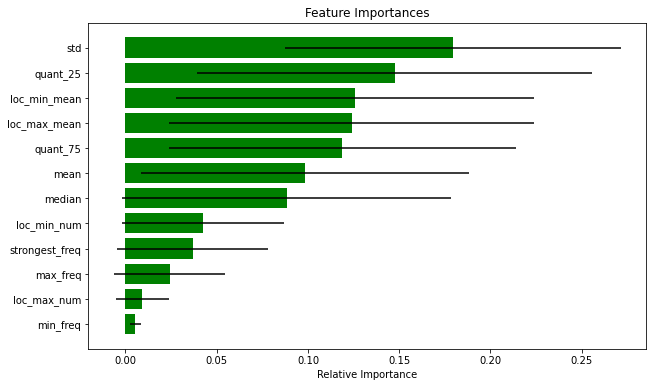

In [97]:
features = ['mean', 'std', 'median', 'quant_25', 'quant_75', 'loc_max_mean', 
            'loc_max_num', 'loc_min_mean', 'loc_min_num', 'strongest_freq', 
            'min_freq', 'max_freq']

importances = best_m.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_m.estimators_],
             axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], xerr=std[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Create meta data DataFrames from all observations to support super well classification

This basically follows the same steps as before.

In [98]:
#%%time

obs_cols = [col for col in list(dfs.values())[0].columns if 'obs' in col]
model_names = [key.split('/')[-2] for key in dfs.keys()]

df_all = pd.DataFrame()
model_dfs = []

# concat meta data for obs horizontally
for model_df_raw, model_name in zip(dfs.values(), model_names):
    
    # save meta data for all obs from one model to this df
    model_df = pd.DataFrame()

    for obs_name in obs_cols:
        series = model_df_raw[obs_name].values
        meta_df = proc_ser(series, model_name, obs_name)
        model_df = pd.concat([model_df, meta_df], axis=1)

    model_dfs.append(model_df)

# concat meta data for obs vertically
for df in model_dfs:
    df_all = pd.concat([df_all, df], axis=0)

# replace categorical freq_iv_obs_ features with left and right boundary values
for obs_name in obs_cols: 
    min_freqs, max_freqs = [], []
    for iv in df_all['freq_iv_' + obs_name]:
        min_freqs.append(iv.left)
        max_freqs.append(iv.right)
    df_all['min_freq_' + obs_name] = min_freqs
    df_all['max_freq_' + obs_name] = max_freqs

df_all = df_all.drop(['freq_iv_'+obs_name for obs_name in obs_cols], axis=1)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



Drop columns with very many NaNs manually. These probally occurred because the data was binary.

In [0]:
#loc_max_cols = [col for col in df_all.columns if '_mean_' in col]
#
#for col in loc_max_cols:
#    print(col)
#    print(np.where(df_all[col].isna()))

nan_cols = ['loc_max_mean_obs_8',
            'loc_min_mean_obs_8',
            'loc_max_mean_obs_22',
            'loc_min_mean_obs_22',
            'loc_max_mean_obs_23',
            'loc_min_mean_obs_23'
            ]

df_all = df_all.drop(nan_cols, axis=1)

In [0]:
# drop samples with NaNs, Keep only the rows with at least half non-NA values.
df_all = df_all.dropna(axis=0)#, thresh=df_all.shape[1]*//2)

In [101]:
df_all

,model,mean_obs_0,std_obs_0,median_obs_0,quant_25_obs_0,quant_75_obs_0,loc_max_mean_obs_0,loc_max_num_obs_0,loc_min_mean_obs_0,loc_min_num_obs_0,strongest_freq_obs_0,model,mean_obs_1,std_obs_1,median_obs_1,quant_25_obs_1,quant_75_obs_1,loc_max_mean_obs_1,loc_max_num_obs_1,loc_min_mean_obs_1,loc_min_num_obs_1,strongest_freq_obs_1,model,mean_obs_2,std_obs_2,median_obs_2,quant_25_obs_2,quant_75_obs_2,loc_max_mean_obs_2,loc_max_num_obs_2,loc_min_mean_obs_2,loc_min_num_obs_2,strongest_freq_obs_2,model,mean_obs_3,std_obs_3,median_obs_3,quant_25_obs_3,quant_75_obs_3,loc_max_mean_obs_3,...,min_freq_obs_4,max_freq_obs_4,min_freq_obs_5,max_freq_obs_5,min_freq_obs_6,max_freq_obs_6,min_freq_obs_7,max_freq_obs_7,min_freq_obs_8,max_freq_obs_8,min_freq_obs_9,max_freq_obs_9,min_freq_obs_10,max_freq_obs_10,min_freq_obs_11,max_freq_obs_11,min_freq_obs_12,max_freq_obs_12,min_freq_obs_13,max_freq_obs_13,min_freq_obs_14,max_freq_obs_14,min_freq_obs_15,max_freq_obs_15,min_freq_obs_16,max_freq_obs_16,min_freq_obs_17,max_freq_obs_17,min_freq_obs_18,max_freq_obs_18,min_freq_obs_19,max_freq_obs_19,min_freq_obs_20,max_freq_obs_20,min_freq_obs_21,max_freq_obs_21,min_freq_obs_22,max_freq_obs_22,min_freq_obs_23,max_freq_obs_23
0,ddpg,-0.853504,0.273517,-0.938479,-1.068344,-0.741993,-1.035356,2,-1.070290,3,0.010101,ddpg,-0.013496,0.043376,0.003692,-0.044664,0.016359,0.009186,7,-0.035682,8,0.010101,ddpg,0.220738,0.175425,0.203086,0.072120,0.383061,0.301053,6,0.167084,7,0.010101,ddpg,-0.008340,0.049192,-0.017464,-0.038323,0.025515,0.068054,...,0.010101,0.060606,0.010101,0.080808,0.070707,0.141414,0.070707,0.141414,0.010101,0.050505,0.010101,0.040404,0.131313,0.171717,0.010101,0.040404,0.030303,0.282828,0.010101,0.141414,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.121212,0.222222,0.121212,0.222222
1,ddpg,-0.470181,0.091547,-0.499046,-0.533494,-0.385231,-0.459897,4,-0.465425,5,0.010101,ddpg,0.004820,0.023948,0.003922,-0.012235,0.017538,0.033159,8,-0.018844,6,0.010101,ddpg,0.558390,0.043156,0.549954,0.527531,0.577639,0.605220,7,0.522546,7,0.010101,ddpg,-0.002187,0.059270,0.002715,-0.038994,0.033738,0.080891,...,0.020202,0.121212,0.090909,0.131313,0.010101,0.070707,0.020202,0.272727,0.121212,0.494949,0.010101,0.121212,0.101010,0.141414,0.010101,0.121212,0.121212,0.252525,0.040404,0.151515,0.010101,0.090909,0.010101,0.060606,0.010101,0.060606,0.010101,0.090909,0.010101,0.060606,0.010101,0.060606,0.010101,0.121212,0.010101,0.070707,0.010101,0.040404,0.121212,0.222222
2,ddpg,-0.330160,0.079464,-0.345907,-0.391146,-0.291972,-0.294264,6,-0.380089,5,0.020202,ddpg,0.005769,0.020681,0.005253,-0.009902,0.024628,0.034898,6,-0.020280,6,0.010101,ddpg,0.579799,0.042263,0.583704,0.564355,0.609540,0.607997,6,0.565758,7,0.020202,ddpg,-0.015584,0.074693,-0.013175,-0.067958,0.043527,0.087969,...,0.010101,0.070707,0.070707,0.141414,0.010101,0.040404,0.010101,0.242424,0.121212,0.494949,0.010101,0.121212,0.070707,0.141414,0.010101,0.131313,0.131313,0.262626,0.060606,0.121212,0.010101,0.070707,0.010101,0.070707,0.010101,0.070707,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.010101,0.040404,0.121212,0.222222
3,ddpg,-0.459364,0.112782,-0.506315,-0.551207,-0.365141,-0.475298,5,-0.506116,6,0.010101,ddpg,-0.003402,0.024575,-0.006819,-0.020926,0.013976,0.027132,6,-0.024078,6,0.010101,ddpg,0.550255,0.075851,0.547684,0.483569,0.623126,0.583464,7,0.503918,7,0.010101,ddpg,0.009761,0.075690,0.016845,-0.022709,0.058191,0.097306,...,0.010101,0.101010,0.050505,0.131313,0.010101,0.060606,0.020202,0.262626,0.121212,0.494949,0.010101,0.131313,0.070707,0.131313,0.010101,0.131313,0.121212,0.252525,0.030303,0.131313,0.010101,0.060606,0.010101,0.050505,0.010101,0.050505,0.010101,0.080808,0.010101,0.121212,0.010101,0.070707,0.010101,0.080808,0.010101,0.080808,0.010101,0.040404,0.121212,0.222222
4,ddpg,-0.416320,0.186713,-0.371755,-0.612672,-0.278382,-0.320085,5

Train new Random Forest model on this larger dataset with n_obs times more features and evaluate its classification accuracy. It should be a lot better.

In [102]:
non_model_cols = [col for col in df_all.columns if col is not 'model']
X = df_all[non_model_cols]
y = df_all['model'].iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

multi_m = RandomForestClassifier()
multi_m.fit(X_train, y_train)

multi_m.score(X_test, y_test)

1.0

Perfect score.

## Feature importance of the 306 features

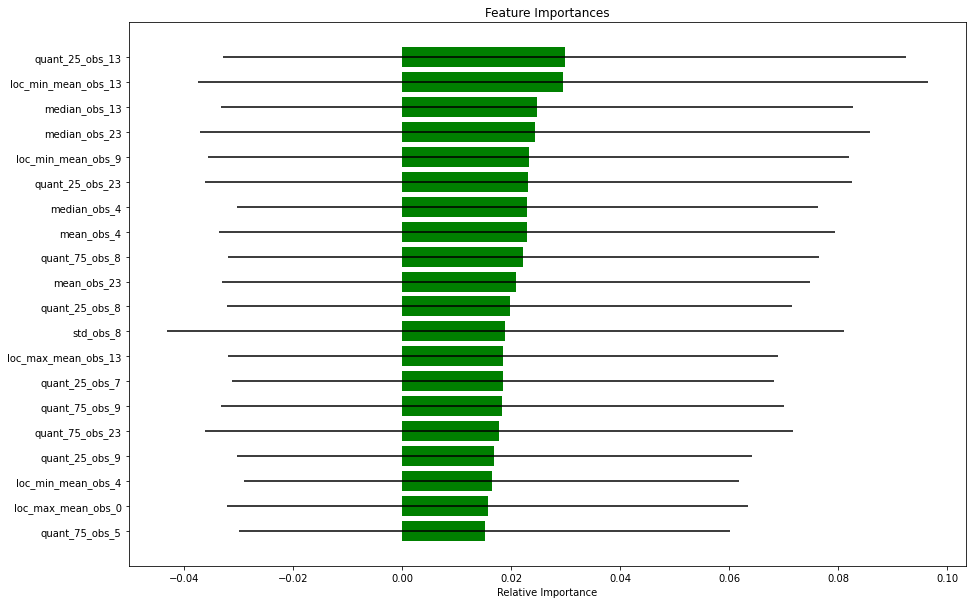

In [103]:
n = 20

features = non_model_cols

importances = multi_m.feature_importances_
std = np.std([tree.feature_importances_ for tree in multi_m.estimators_],
             axis=0)
indices = np.argsort(importances)[-n:] # most important at the end

plt.figure(figsize=(15, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], xerr=std[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()